# Data Analysis of SemEval Train/Val/Test Sets

Exploratory data analysis of the SemEval-2026 Task 13 datasets and the supplementary DroidCollection dataset. Visualises label balance, language distributions, and code-length statistics across splits.

## Contents
1. Imports & Data Loading
2. Label & Language Distribution
3. Code Length Distributions (characters, lines, tokens)
4. Length Stats per Label & Language (box-plots)
5. Summary Statistics Table
6. Test Set Analysis
7. Additional Dataset Analysis (DroidCollection)
8. Cross-Dataset Comparison
    - 8a. Dataset Size & Label Balance
    - 8b. Language Overlap & Proportions
    - 8c. Code Length Distributions
    - 8d. Summary Statistics Side-by-Side

In [1]:
import pandas as pd

train = pd.read_parquet("data/semeval/train.parquet")
val   = pd.read_parquet("data/semeval/validation.parquet")

print("Train shape:", train.shape)
print("Val   shape:", val.shape)
print()
print(train.dtypes)
print()
train.head(3)

Train shape: (500000, 4)
Val   shape: (100000, 4)

code         object
generator    object
label         int64
language     object
dtype: object



,code,generator,label,language
0,"(a, b, c, d) = [int(x) for x in input().split(...",human,0,Python
1,valid version for the language; all others can...,Qwen/Qwen2.5-Coder-1.5B,1,Python
2,python\ndef min_cards_to_flip(s):\n vowels ...,Qwen/Qwen2.5-Coder-7B-Instruct,1,Python


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Combine train + val for overall view
df = pd.concat([train.assign(split="train"), val.assign(split="val")], ignore_index=True)
df["label_name"] = df["label"].map({0: "Human", 1: "AI-generated"})

# Derived features
df["code_len"]    = df["code"].str.len()
df["line_count"]  = df["code"].str.count("\n") + 1
df["token_count"] = df["code"].str.split().apply(len)

print(f"Total rows: {len(df):,}")
print(f"\nLabel distribution:\n{df['label_name'].value_counts()}")
print(f"\nLanguages:\n{df['language'].value_counts()}")
print(f"\nGenerators (top 10):\n{df['generator'].value_counts().head(10)}")

Total rows: 600,000

Label distribution:
label_name
AI-generated    313830
Human           286170
Name: count, dtype: int64

Languages:
language
Python    548767
C++        28071
Java       23162
Name: count, dtype: int64

Generators (top 10):
generator
human                                  286170
microsoft/Phi-3-medium-4k-instruct      19710
microsoft/Phi-3.5-mini-instruct         11916
01-ai/Yi-Coder-9B                       11765
bigcode/starcoder                       11637
microsoft/phi-2                         11460
Qwen/Qwen2.5-Coder-1.5B-Instruct        10920
bigcode/starcoder2-15b                  10696
meta-llama/Llama-3.3-70B-Instruct       10516
codellama/CodeLlama-70b-Instruct-hf     10457
Name: count, dtype: int64


## 1. Label & Language Distribution

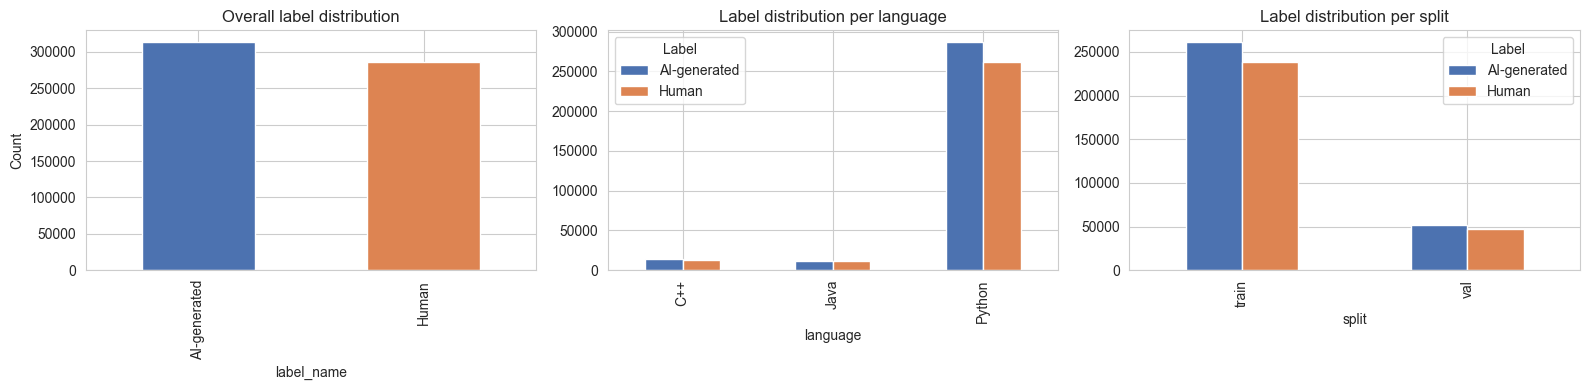

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# 1a  Overall label counts
df["label_name"].value_counts().plot.bar(ax=axes[0], color=["#4c72b0", "#dd8452"])
axes[0].set_title("Overall label distribution")
axes[0].set_ylabel("Count")

# 1b  Label counts per language
ct = df.groupby(["language", "label_name"]).size().unstack()
ct.plot.bar(ax=axes[1], color=["#4c72b0", "#dd8452"])
axes[1].set_title("Label distribution per language")
axes[1].legend(title="Label")

# 1c  Train vs Val split
df.groupby(["split", "label_name"]).size().unstack().plot.bar(ax=axes[2], color=["#4c72b0", "#dd8452"])
axes[2].set_title("Label distribution per split")
axes[2].legend(title="Label")

plt.tight_layout()
plt.show()

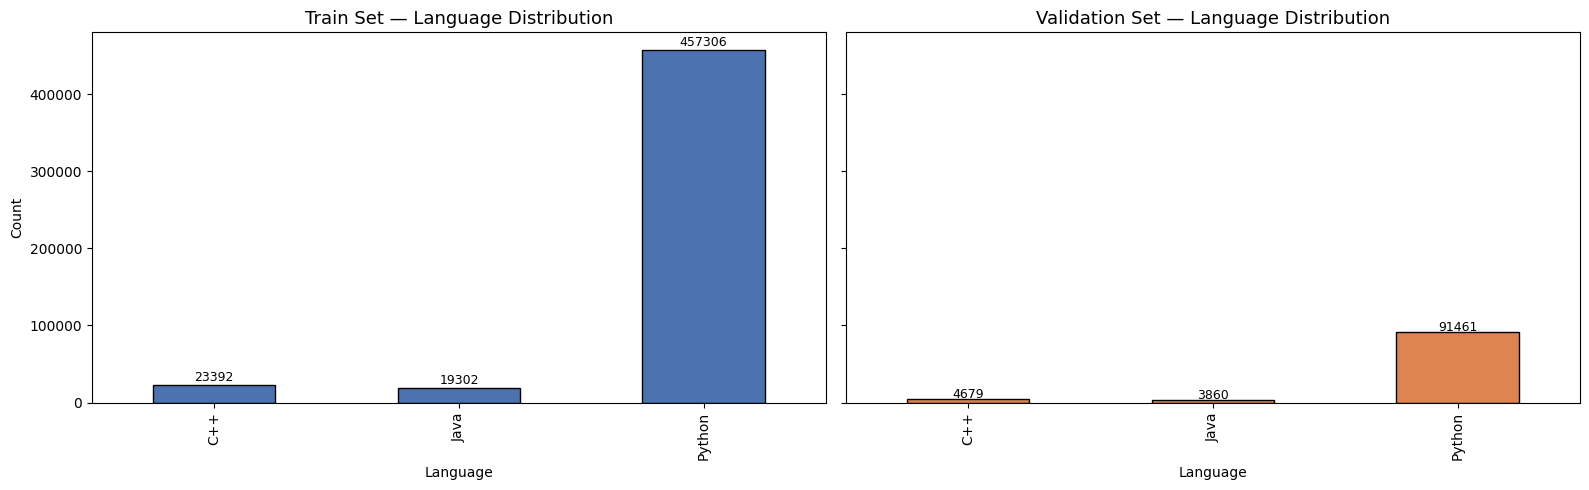

In [3]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

train_lang = train["language"].value_counts().sort_index()
val_lang = val["language"].value_counts().sort_index()

train_lang.plot.bar(ax=axes[0], color="#4c72b0", edgecolor="black")
axes[0].set_title("Train Set — Language Distribution", fontsize=13)
axes[0].set_xlabel("Language")
axes[0].set_ylabel("Count")
for i, v in enumerate(train_lang):
    axes[0].text(i, v + max(train_lang) * 0.01, str(v), ha="center", fontsize=9)

val_lang.plot.bar(ax=axes[1], color="#dd8452", edgecolor="black")
axes[1].set_title("Validation Set — Language Distribution", fontsize=13)
axes[1].set_xlabel("Language")
for i, v in enumerate(val_lang):
    axes[1].text(i, v + max(val_lang) * 0.01, str(v), ha="center", fontsize=9)

plt.tight_layout()
plt.show()

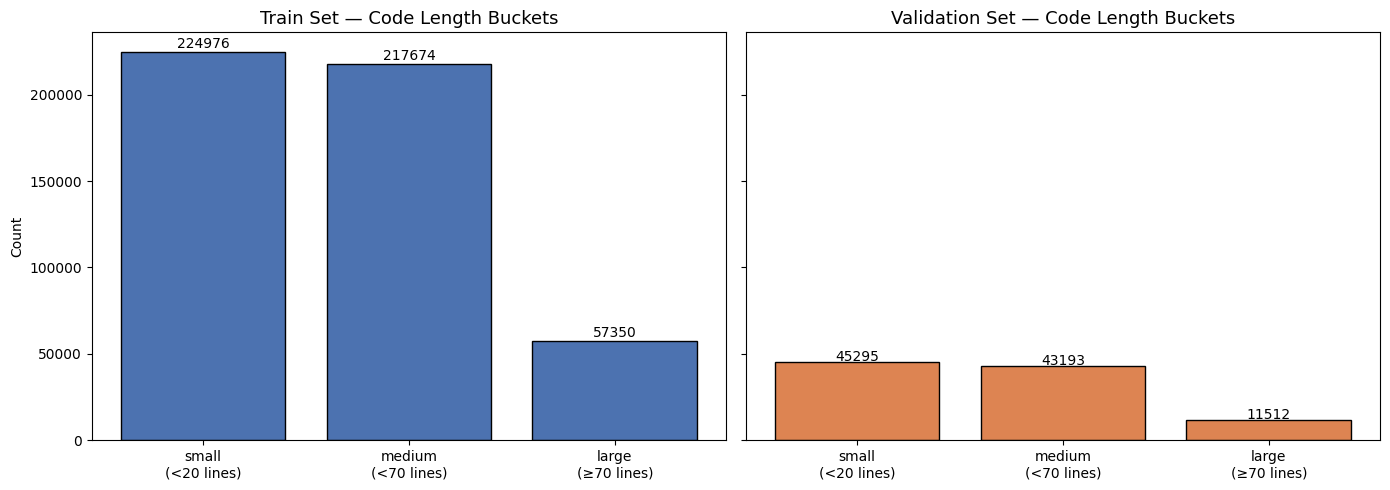

In [5]:
def size_bucket(code):
    total_lines = code.count("\n") + 1
    if total_lines < 20:
        return "small"
    elif total_lines <= 70:
        return "medium"
    else:
        return "large"

bucket_order = ["small", "medium", "large"]
bucket_labels = ["small\n(<20 lines)", "medium\n(<70 lines)", "large\n(≥70 lines)"]

train_buckets = train["code"].apply(size_bucket).value_counts().reindex(bucket_order, fill_value=0)
val_buckets = val["code"].apply(size_bucket).value_counts().reindex(bucket_order, fill_value=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axes[0].bar(bucket_labels, train_buckets.values, color="#4c72b0", edgecolor="black")
axes[0].set_title("Train Set — Code Length Buckets", fontsize=13)
axes[0].set_ylabel("Count")
for i, v in enumerate(train_buckets.values):
    axes[0].text(i, v + max(train_buckets) * 0.01, str(v), ha="center", fontsize=10)

axes[1].bar(bucket_labels, val_buckets.values, color="#dd8452", edgecolor="black")
axes[1].set_title("Validation Set — Code Length Buckets", fontsize=13)
for i, v in enumerate(val_buckets.values):
    axes[1].text(i, v + max(val_buckets) * 0.01, str(v), ha="center", fontsize=10)

plt.tight_layout()
plt.show()

## 2. Code Length Distributions (characters, lines, tokens)

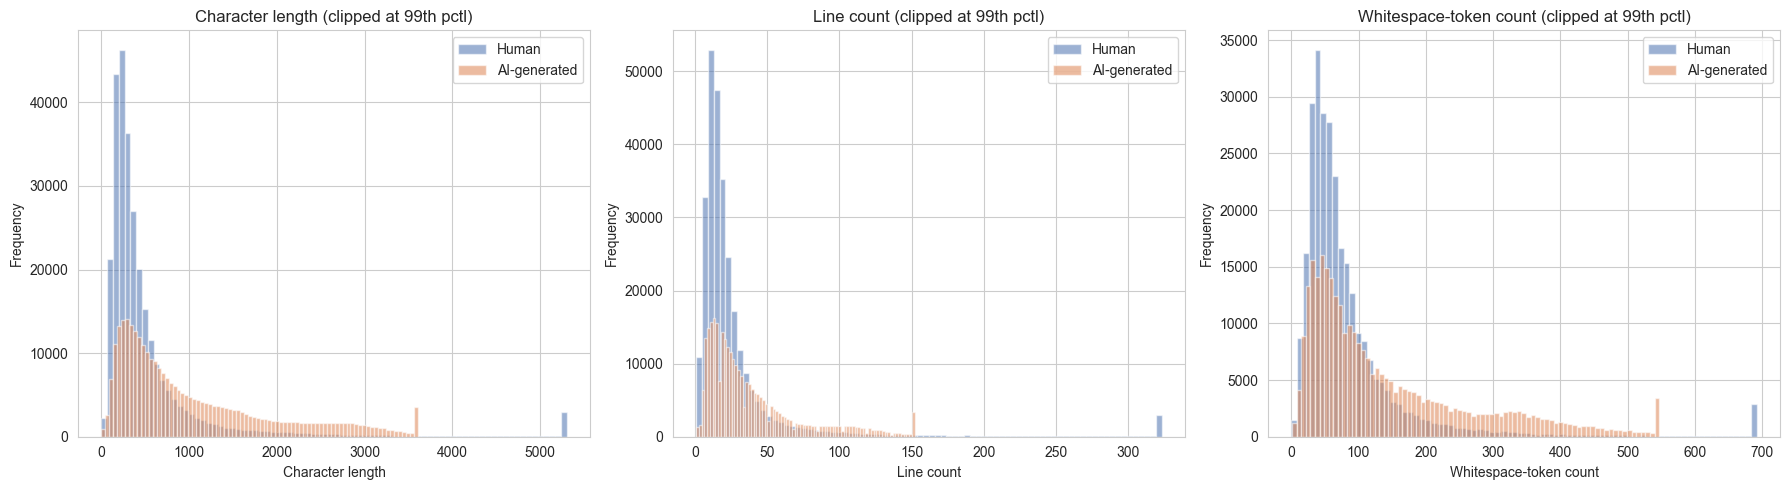

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
palette = {"Human": "#4c72b0", "AI-generated": "#dd8452"}

for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Whitespace-token count"],
):
    for label, color in palette.items():
        subset = df.loc[df["label_name"] == label, col]
        ax.hist(subset.clip(upper=subset.quantile(0.99)),
                bins=80, alpha=0.55, label=label, color=color)
    ax.set_title(f"{title} (clipped at 99th pctl)")
    ax.set_xlabel(title)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

## 3. Length stats per label (box-plots) & per language

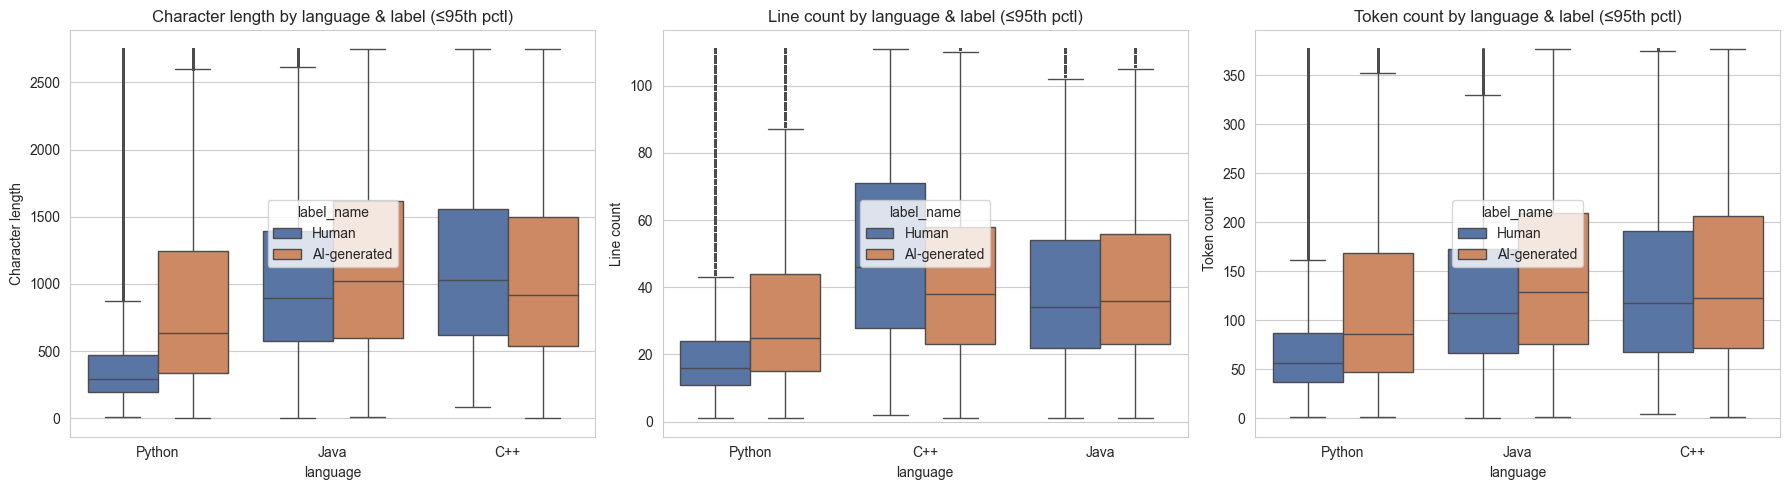

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Token count"],
):
    upper = df[col].quantile(0.95)
    sns.boxplot(
        data=df[df[col] <= upper],
        x="language", y=col, hue="label_name",
        palette=palette, ax=ax, fliersize=1,
    )
    ax.set_title(f"{title} by language & label (≤95th pctl)")
    ax.set_ylabel(title)

plt.tight_layout()
plt.show()

## 4. Summary statistics table

In [6]:
stats = (
    df.groupby(["language", "label_name"])[["code_len", "line_count", "token_count"]]
      .describe()
      .round(1)
)
display(stats)

code_len                                               \
                          count    mean     std   min    25%     50%     75%   
language label_name                                                            
C++      AI-generated   14694.0  1257.3   885.9   3.0  572.0  1018.5  1724.8   
         Human          13377.0  1933.1  2916.3  86.0  702.0  1214.0  2125.0   
Java     AI-generated   12092.0  1407.0   962.5   6.0  648.8  1165.0  1968.0   
         Human          11070.0  2720.8  4513.4   0.0  679.0  1193.0  2753.8   
Python   AI-generated  287044.0  1027.2   887.0   1.0  356.0   695.0  1453.0   
         Human         261723.0   441.9  1220.4  11.0  197.0   297.0   475.0   

                                line_count         ...                 \
                            max      count   mean  ...    75%     max   
language label_name                                ...                  
C++      AI-generated    5717.0    14694.0   49.1  ...   64.0   292.0   
         Human          86109.0    13377.0  113.9  ...  134.0  3775.0   
Java     AI-generated    6712.0    12092.0   48.4  ...   63.0   296.0   
         Human          79243.0    11070.0  167.2  ...  161.0  3295.0   
Python   AI-generated   11964.0   287044.0   39.1  ...   50.0   298.0   
         Human         475006.0   261723.0   22.9  ...   25.0  3921.0   

                      token_count                                         \
                            count   mean    std  min   25%    50%    75%   
language label_name                                                        
C++      AI-generated     14694.0  174.6  129.0  1.0  77.0  137.0  239.0   
         Human            13377.0  246.3  388.2  4.0  77.0  140.0  266.0   
Java     AI-generated     12092.0  181.1  130.6  1.0  82.0  143.5  251.0   
         Human            11070.0  317.8  562.5  0.0  77.0  135.0  301.8   
Python   AI-generated    287044.0  143.6  128.1  1.0  49.0   95.0  201.0   
         Human           261723.0   77.2  115.5  1.0  37.0   56.0   88.0   

                                
                           max  
language label_name             
C++      AI-generated    849.0  
         Human          7519.0  
Java     AI-generated    856.0  
         Human         11831.0  
Python   AI-generated    990.0  
         Human         23974.0  

[6 rows x 24 columns]

# Test set analysis

In [3]:
df_test = pd.read_parquet("data/semeval/processed/df_test_new_with_lang.parquet")
print("Shape:", df_test.shape)
print()
print(df_test.dtypes)
print()
df_test.head(3)

Shape: (500000, 3)

ID          int64
code          str
language      str
dtype: object



,ID,code,language
0,0,"(H, W) = map(int, input().split())\nA = [list(...",python
1,2,"n = int(input())\nt = list(map(int, input().sp...",python
2,5,import sys\n\nclass LazySegmentTree:\n def ...,python


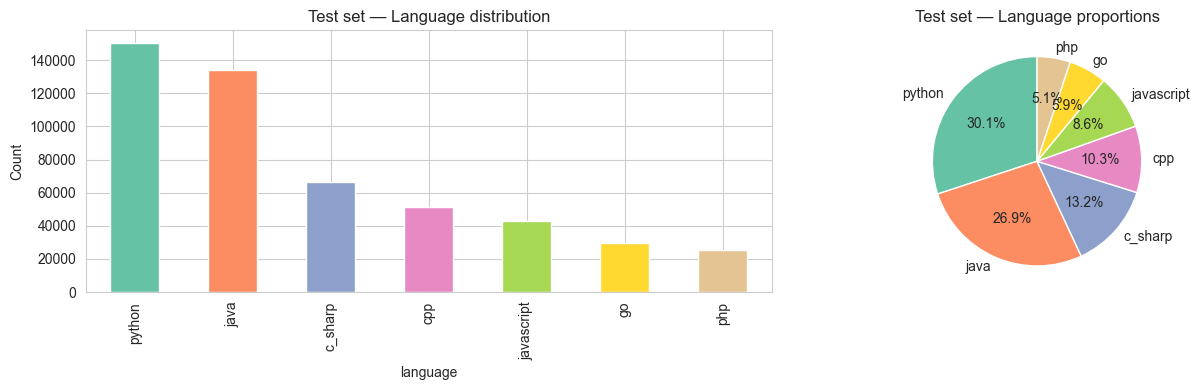

In [8]:
# Derived length features for test set
df_test["code_len"]    = df_test["code"].str.len()
df_test["line_count"]  = df_test["code"].str.count("\n") + 1
df_test["token_count"] = df_test["code"].str.split().apply(len)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Language distribution
lang_counts = df_test["language"].value_counts()
lang_counts.plot.bar(ax=axes[0], color=sns.color_palette("Set2", len(lang_counts)))
axes[0].set_title("Test set — Language distribution")
axes[0].set_ylabel("Count")

# Language proportion (pie)
lang_counts.plot.pie(ax=axes[1], autopct="%1.1f%%", startangle=90,
                     colors=sns.color_palette("Set2", len(lang_counts)))
axes[1].set_title("Test set — Language proportions")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_45312\2567680594.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\User\AppData\Local\Temp\ipykernel_45312\2567680594.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\User\AppData\Local\Temp\ipykernel_45312\2567680594.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


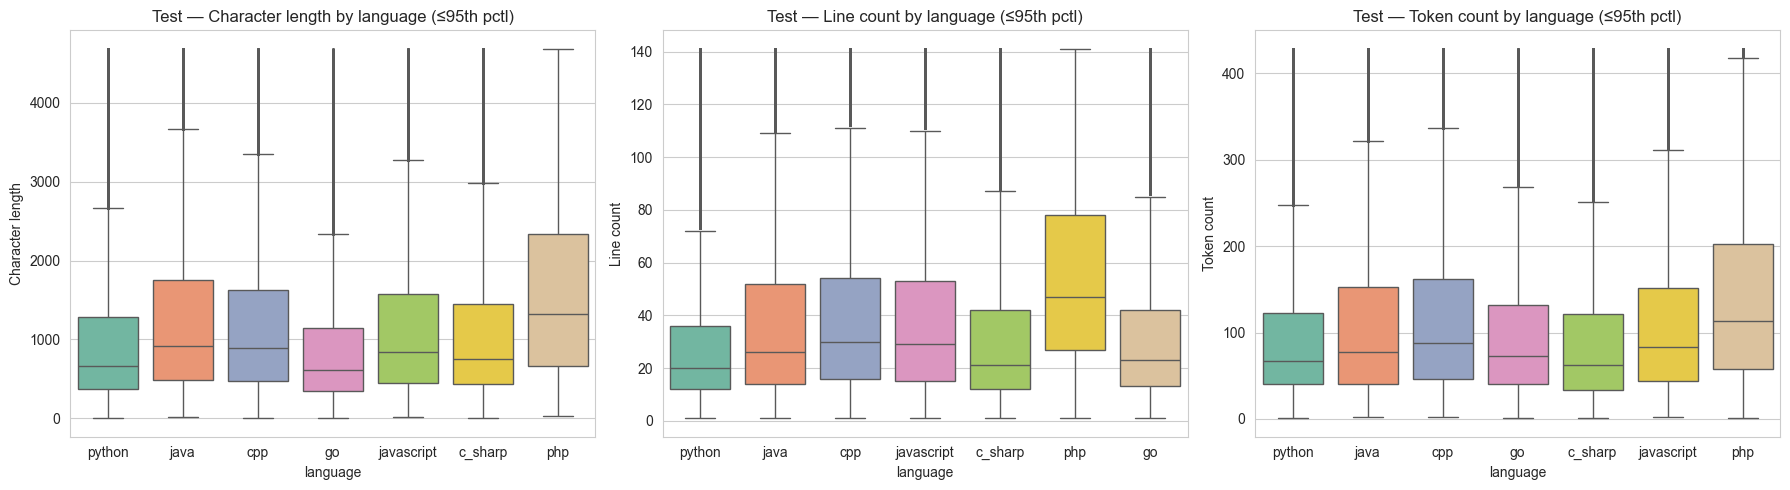

In [9]:
# Length distributions per language (test set)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Token count"],
):
    upper = df_test[col].quantile(0.95)
    sns.boxplot(
        data=df_test[df_test[col] <= upper],
        x="language", y=col, hue="language",
        palette="Set2", ax=ax, fliersize=1, legend=False,
    )
    ax.set_title(f"Test — {title} by language (≤95th pctl)")
    ax.set_ylabel(title)

plt.tight_layout()
plt.show()

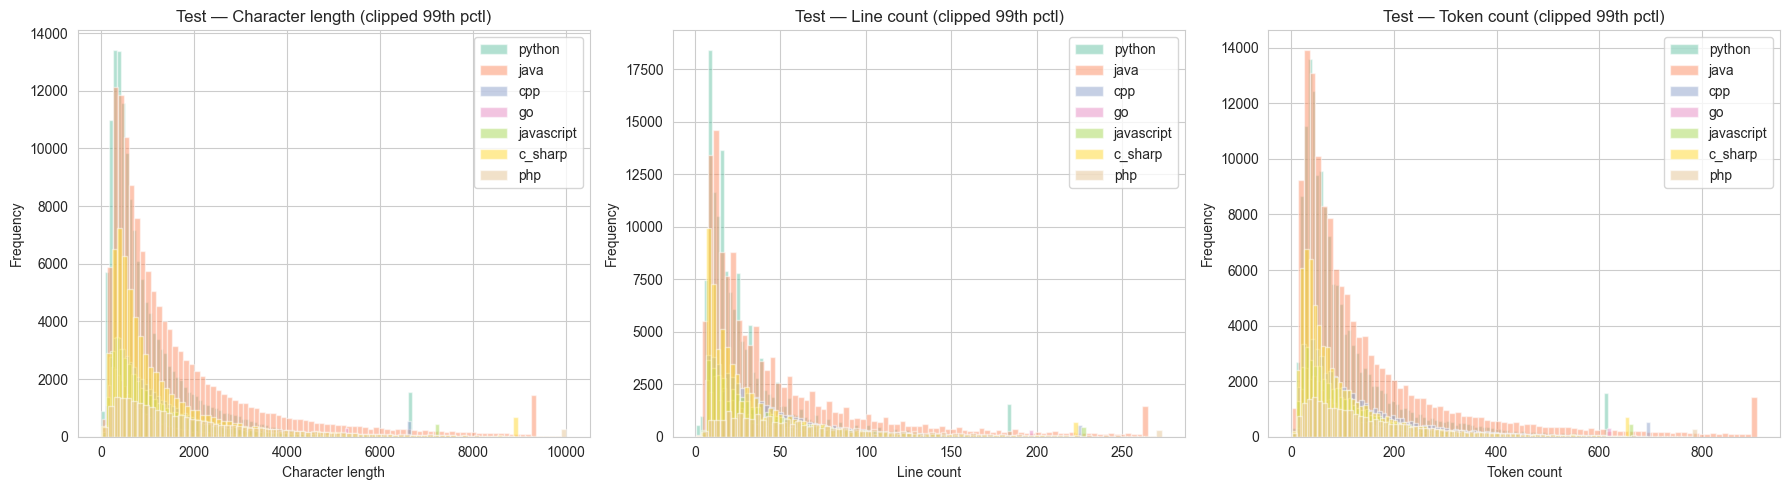

In [10]:
# Histograms — character length per language (test set)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Token count"],
):
    for lang, color in zip(df_test["language"].unique(), test_palette):
        subset = df_test.loc[df_test["language"] == lang, col]
        ax.hist(subset.clip(upper=subset.quantile(0.99)),
                bins=80, alpha=0.5, label=lang, color=color)
    ax.set_title(f"Test — {title} (clipped 99th pctl)")
    ax.set_xlabel(title)
    ax.set_ylabel("Frequency")
    ax.legend()

plt.tight_layout()
plt.show()

In [11]:
# Summary stats for test set
test_stats = (
    df_test.groupby("language")[["code_len", "line_count", "token_count"]]
           .describe()
           .round(1)
)
display(test_stats)

code_len                                                        \
               count    mean     std   min    25%     50%     75%      max   
language                                                                     
c_sharp      66142.0  1413.5  1711.3   2.0  443.0   803.5  1652.0  23381.0   
cpp          51439.0  1355.7  1373.9   8.0  478.0   921.0  1738.5  53500.0   
go           29349.0   962.7  1014.6   6.0  348.0   621.0  1177.0  12259.0   
java        134307.0  1729.3  1951.3  15.0  514.0  1019.0  2137.0  54080.0   
javascript   42758.0  1375.3  1459.1  16.0  460.0   885.0  1719.0  24162.0   
php          25630.0  2273.5  2176.3  28.0  748.0  1556.0  3053.0  23146.0   
python      150375.0  1127.1  1303.3   3.0  376.0   683.0  1366.0  42664.0   

           line_count        ...                token_count                \
                count  mean  ...    75%     max       count   mean    std   
language                     ...                                            
c_sharp       66142.0  38.0  ...   46.0   299.0     66142.0  110.1  129.4   
cpp           51439.0  46.3  ...   58.0  2863.0     51439.0  139.5  148.2   
go            29349.0  35.8  ...   44.0   297.0     29349.0  114.0  118.4   
java         134307.0  50.7  ...   63.0  3489.0    134307.0  156.7  190.3   
javascript    42758.0  45.8  ...   58.0   298.0     42758.0  131.2  134.6   
php           25630.0  75.2  ...  102.0   299.0     25630.0  181.4  169.7   
python       150375.0  32.8  ...   38.0  1639.0    150375.0  112.3  129.2   

                                             
            min   25%    50%    75%     max  
language                                     
c_sharp     1.0  35.0   64.0  132.0  2035.0  
cpp         2.0  48.0   93.0  178.0  6695.0  
go          1.0  42.0   76.0  139.0  1375.0  
java        2.0  44.0   88.0  188.0  7587.0  
javascript  2.0  46.0   88.0  164.0  2085.0  
php         1.0  63.0  126.0  241.0  1928.0  
python      1.0  40.0   69.0  132.0  6828.0  

[7 rows x 24 columns]

# Additional dataset analysis

In [4]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("project-droid/DroidCollection")

d:\stuff\SemEvalTask13-SubtaskA\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\stuff\SemEvalTask13-SubtaskA\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\User\.cache\huggingface\hub\datasets--project-droid--DroidCollection. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to 

In [5]:
from datasets import concatenate_datasets


all_ds = concatenate_datasets([ds["train"], ds["dev"], ds["test"]])

test_data_add = all_ds.to_pandas()

In [6]:
print("Shape:", test_data_add.shape)
print()
print(test_data_add.dtypes)
print()
print("Unique source values:", test_data_add["source"].unique() if "source" in test_data_add.columns else "N/A")
print()
test_data_add.head(3)

Shape: (1058248, 9)

Code                str
Generator           str
Generation_Mode     str
Source              str
Language            str
Sampling_Params     str
Rewriting_Params    str
Label               str
Model_Family        str
dtype: object

Unique source values: N/A



,Code,Generator,Generation_Mode,Source,Language,Sampling_Params,Rewriting_Params,Label,Model_Family
0,#include <iostream>\n#include <vector>\n#inclu...,GPT-4o-mini,INSTRUCT,DROID_PERSONAHUB,C++,,,MACHINE_GENERATED,gpt-4o-mini
1,"def is_circle_inside_rectangle(W, H, x, y, r):...",microsoft/Phi-3-small-8k-instruct,INSTRUCT,TACO,Python,"{'best_of': None, 'max_tokens': 1024, 'tempera...",,MACHINE_GENERATED,microsoft
2,#include <stdio.h>\n#include <stdlib.h>\n\n#de...,GPT-4o-mini,INSTRUCT,DROID_PERSONAHUB,C,,,MACHINE_GENERATED,gpt-4o-mini


In [7]:
# Normalize label: "human" → Human, everything else → AI
# The Label column has values like MACHINE_GENERATED, HUMAN_WRITTEN, etc.
print("Raw Label values:", test_data_add["Label"].unique())
print()

# Map: if label contains "HUMAN" → "Human", else "AI"
test_data_add["label_norm"] = test_data_add["Label"].apply(
    lambda x: "Human" if "HUMAN" in str(x).upper() else "AI"
)
# Also check Generator column for "human" as fallback
mask_human_gen = test_data_add["Generator"].str.lower() == "human"
test_data_add.loc[mask_human_gen, "label_norm"] = "Human"

print("Normalized label distribution:")
print(test_data_add["label_norm"].value_counts())
print()
print("Language distribution:")
print(test_data_add["Language"].value_counts())

Raw Label values: <ArrowStringArray>
[            'MACHINE_GENERATED',               'MACHINE_REFINED',
               'HUMAN_GENERATED', 'MACHINE_GENERATED_ADVERSARIAL']
Length: 4, dtype: str

Normalized label distribution:
label_norm
AI       558938
Human    499310
Name: count, dtype: int64

Language distribution:
Language
Python        328383
Java          271802
C#            118565
C++           103471
JavaScript     95285
Go             67534
C              54401
PHP            11232
Rust            7575
Name: count, dtype: int64


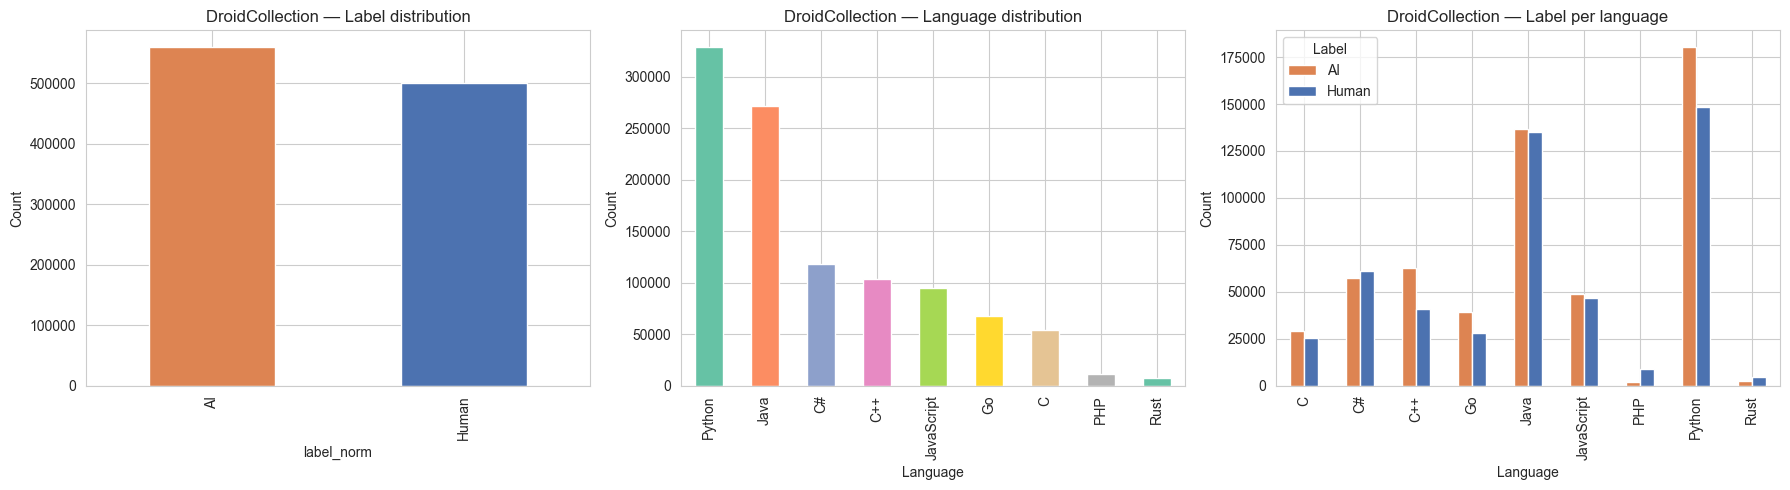

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
add_palette = {"Human": "#4c72b0", "AI": "#dd8452"}

# 1 — Overall label distribution
test_data_add["label_norm"].value_counts().plot.bar(
    ax=axes[0], color=[add_palette["AI"], add_palette["Human"]]
)
axes[0].set_title("DroidCollection — Label distribution")
axes[0].set_ylabel("Count")

# 2 — Language distribution
lang_cts = test_data_add["Language"].value_counts()
lang_cts.plot.bar(ax=axes[1], color=sns.color_palette("Set2", len(lang_cts)))
axes[1].set_title("DroidCollection — Language distribution")
axes[1].set_ylabel("Count")

# 3 — Label per language
ct_add = test_data_add.groupby(["Language", "label_norm"]).size().unstack(fill_value=0)
ct_add.plot.bar(ax=axes[2], color=[add_palette["AI"], add_palette["Human"]])
axes[2].set_title("DroidCollection — Label per language")
axes[2].legend(title="Label")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

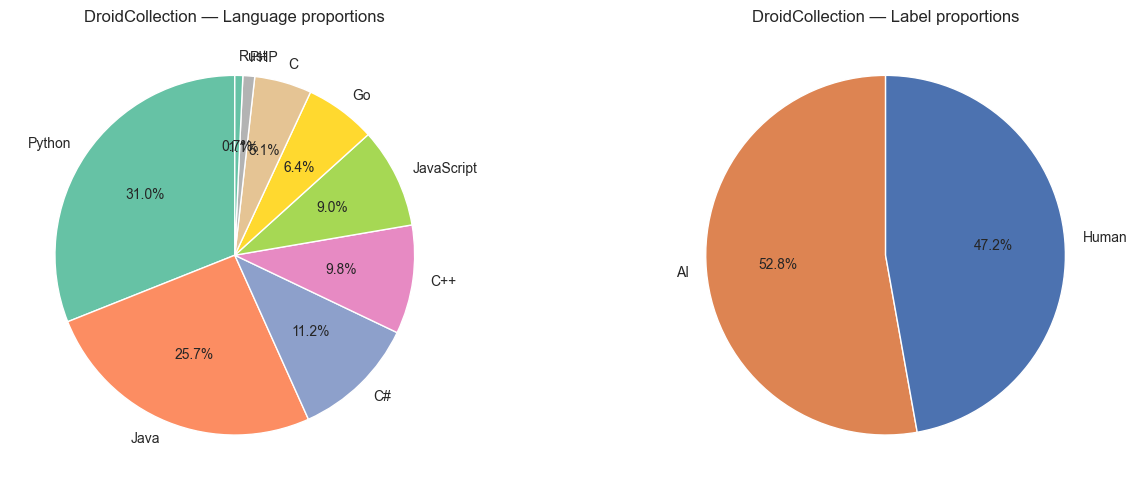

In [9]:
# Language proportions — pie chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lang_cts = test_data_add["Language"].value_counts()
lang_cts.plot.pie(ax=axes[0], autopct="%1.1f%%", startangle=90,
                  colors=sns.color_palette("Set2", len(lang_cts)))
axes[0].set_title("DroidCollection — Language proportions")
axes[0].set_ylabel("")

# Label proportions — pie chart
label_cts = test_data_add["label_norm"].value_counts()
label_cts.plot.pie(ax=axes[1], autopct="%1.1f%%", startangle=90,
                   colors=[add_palette["AI"], add_palette["Human"]])
axes[1].set_title("DroidCollection — Label proportions")
axes[1].set_ylabel("")

plt.tight_layout()
plt.show()

In [10]:
# Detailed raw-label breakdown per language
ct_raw = test_data_add.groupby(["Language", "Label"]).size().unstack(fill_value=0)
display(ct_raw)

Label,HUMAN_GENERATED,MACHINE_GENERATED,MACHINE_GENERATED_ADVERSARIAL,MACHINE_REFINED
Language,,,,
C,25440,12076,11311,5574
C#,61383,17980,23215,15987
C++,40742,42535,11775,8419
Go,28112,20236,11183,8003
Java,135049,50328,48938,37487
JavaScript,46622,23890,14319,10454
PHP,8979,0,2253,0
Python,148211,98196,35597,46379
Rust,4772,0,2803,0


# 5. Cross-Dataset Comparison
Compare **SemEval (train+val)**, **SemEval Test**, and **DroidCollection** across language coverage, label balance, and code-length distributions.

In [12]:
# --- Prepare unified length features for DroidCollection ---
test_data_add["code_len"]    = test_data_add["Code"].str.len()
test_data_add["line_count"]  = test_data_add["Code"].str.count("\n") + 1
test_data_add["token_count"] = test_data_add["Code"].str.split().apply(len)

# --- Ensure test set also has length features ---
if "code_len" not in df_test.columns:
    df_test["code_len"]    = df_test["code"].str.len()
    df_test["line_count"]  = df_test["code"].str.count("\n") + 1
    df_test["token_count"] = df_test["code"].str.split().apply(len)

# --- Build a slim combined DataFrame for side-by-side comparison ---
semeval_slim = df[["language", "label_name", "code_len", "line_count", "token_count"]].copy()
semeval_slim.rename(columns={"language": "lang", "label_name": "label"}, inplace=True)
semeval_slim["dataset"] = "SemEval train+val"

test_slim = df_test[["language", "code_len", "line_count", "token_count"]].copy()
test_slim.rename(columns={"language": "lang"}, inplace=True)
test_slim["label"] = "Unknown"  # no labels in test set
test_slim["dataset"] = "SemEval test"

droid_slim = test_data_add[["Language", "label_norm", "code_len", "line_count", "token_count"]].copy()
droid_slim.rename(columns={"Language": "lang", "label_norm": "label"}, inplace=True)
droid_slim["dataset"] = "DroidCollection"

combined = pd.concat([semeval_slim, test_slim, droid_slim], ignore_index=True)
print("Combined shape:", combined.shape)
print(combined["dataset"].value_counts())

Combined shape: (2158248, 6)
dataset
DroidCollection      1058248
SemEval train+val     600000
SemEval test          500000
Name: count, dtype: int64


### 5a. Dataset size & label balance comparison

,Dataset,Rows,Human,AI,Human %,AI %,Languages
0,DroidCollection,"1,058,248","499,310","558,938",47.2%,52.8%,9
1,SemEval test,"500,000",0,0,0.0%,0.0%,7
2,SemEval train+val,"600,000","286,170","313,830",47.7%,52.3%,3


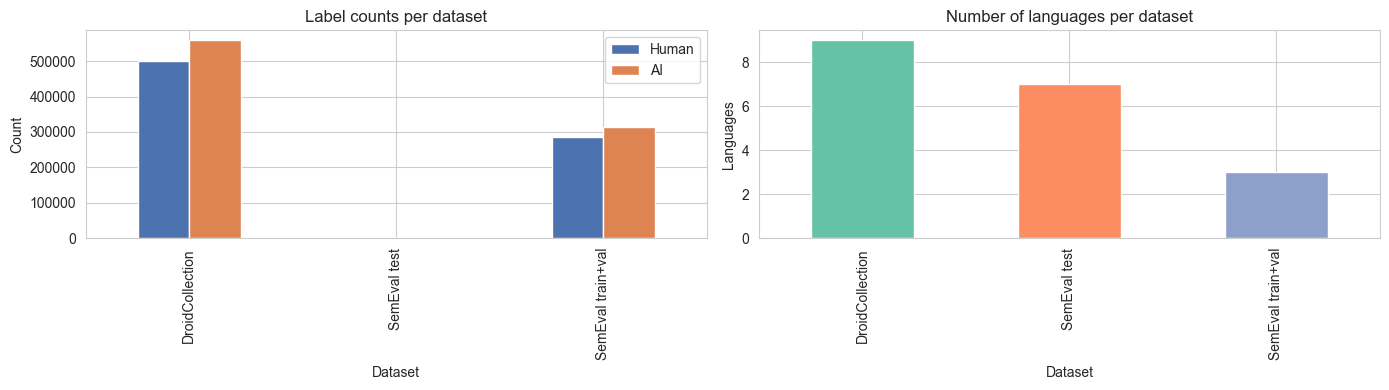

In [13]:
# Summary table: row counts, label ratios, language counts
summary_rows = []
for name, sub in combined.groupby("dataset"):
    n = len(sub)
    n_human = (sub["label"] == "Human").sum()
    n_ai    = (sub["label"].isin(["AI-generated", "AI"])).sum()
    n_langs = sub["lang"].nunique()
    summary_rows.append({
        "Dataset": name,
        "Rows": f"{n:,}",
        "Human": f"{n_human:,}",
        "AI": f"{n_ai:,}",
        "Human %": f"{n_human / n * 100:.1f}%",
        "AI %": f"{n_ai / n * 100:.1f}%",
        "Languages": n_langs,
    })

summary_df = pd.DataFrame(summary_rows)
display(summary_df)

# Bar chart: dataset sizes side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

summary_df_plot = summary_df.copy()
summary_df_plot["Human_n"] = summary_df_plot["Human"].str.replace(",", "").astype(int)
summary_df_plot["AI_n"]    = summary_df_plot["AI"].str.replace(",", "").astype(int)

summary_df_plot.set_index("Dataset")[["Human_n", "AI_n"]].plot.bar(
    ax=axes[0], color=["#4c72b0", "#dd8452"]
)
axes[0].set_title("Label counts per dataset")
axes[0].set_ylabel("Count")
axes[0].legend(["Human", "AI"])

# Language coverage count
summary_df.set_index("Dataset")["Languages"].plot.bar(
    ax=axes[1], color=sns.color_palette("Set2", 3)
)
axes[1].set_title("Number of languages per dataset")
axes[1].set_ylabel("Languages")

plt.tight_layout()
plt.show()

### 5b. Language overlap & proportions

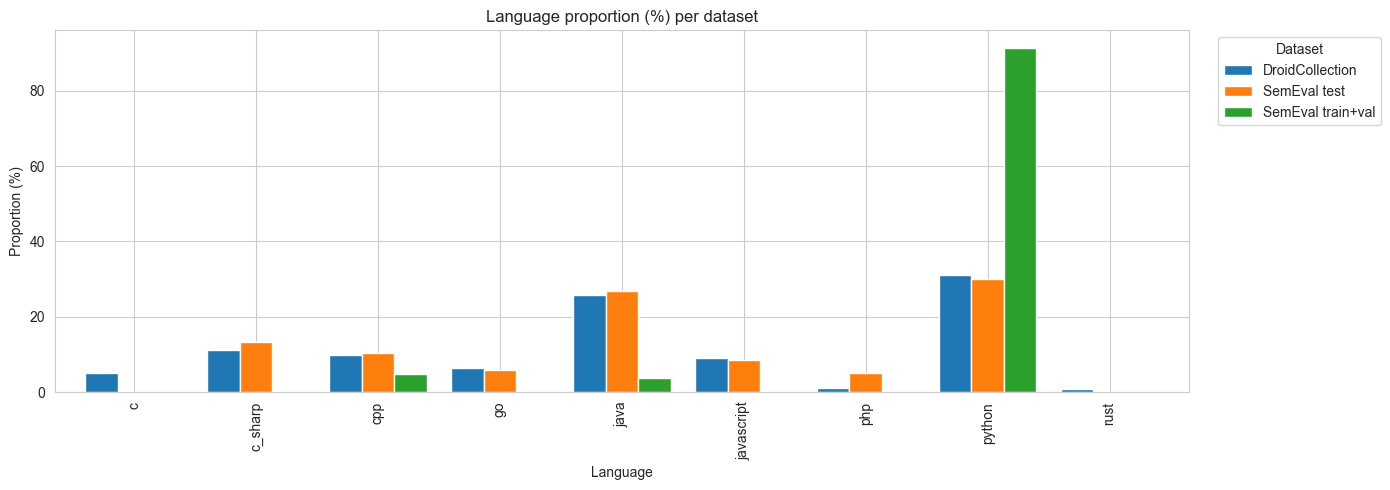

All languages across datasets: ['c', 'c_sharp', 'cpp', 'go', 'java', 'javascript', 'php', 'python', 'rust']
Shared across ALL datasets:    ['cpp', 'java', 'python']
  Unique to DroidCollection: ['c', 'rust']


In [14]:
# Normalize language names to lowercase for fair comparison
combined["lang_lower"] = combined["lang"].str.lower().str.replace("#", "_sharp").str.replace("++", "pp")

# Language proportion per dataset
lang_prop = (
    combined.groupby(["dataset", "lang_lower"]).size()
    .groupby(level=0).transform(lambda x: x / x.sum() * 100)
    .unstack(fill_value=0)
)

fig, ax = plt.subplots(figsize=(14, 5))
lang_prop.T.plot.bar(ax=ax, width=0.8)
ax.set_title("Language proportion (%) per dataset")
ax.set_ylabel("Proportion (%)")
ax.set_xlabel("Language")
ax.legend(title="Dataset", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Show which languages are shared / unique
langs_per_ds = combined.groupby("dataset")["lang_lower"].apply(set)
all_langs = set.union(*langs_per_ds.values)
shared   = set.intersection(*langs_per_ds.values)
print(f"All languages across datasets: {sorted(all_langs)}")
print(f"Shared across ALL datasets:    {sorted(shared)}")
for ds_name, ls in langs_per_ds.items():
    unique = ls - set.union(*(v for k, v in langs_per_ds.items() if k != ds_name))
    if unique:
        print(f"  Unique to {ds_name}: {sorted(unique)}")

### 5c. Code length distributions comparison

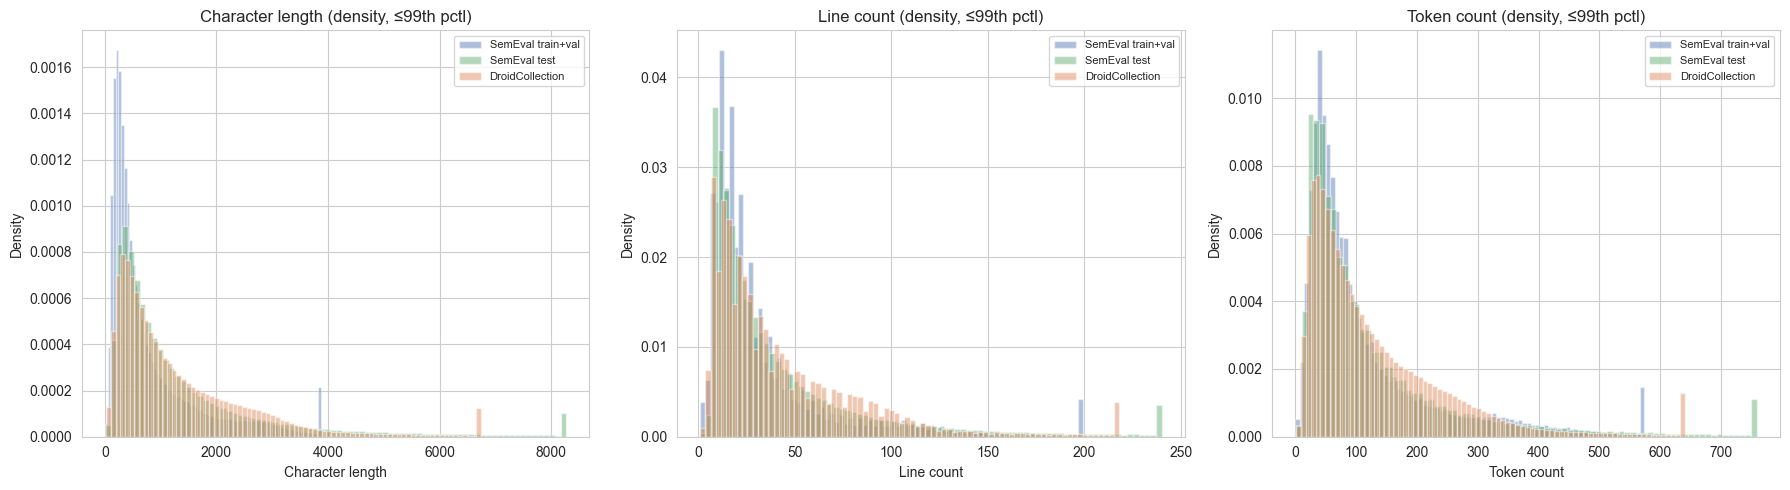

In [15]:
# Overlaid histograms: code_len / line_count / token_count across datasets
ds_palette = {"SemEval train+val": "#4c72b0", "SemEval test": "#55a868", "DroidCollection": "#dd8452"}

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Token count"],
):
    for ds_name, color in ds_palette.items():
        subset = combined.loc[combined["dataset"] == ds_name, col]
        clip_val = subset.quantile(0.99)
        ax.hist(subset.clip(upper=clip_val), bins=80, alpha=0.45,
                label=ds_name, color=color, density=True)
    ax.set_title(f"{title} (density, ≤99th pctl)")
    ax.set_xlabel(title)
    ax.set_ylabel("Density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

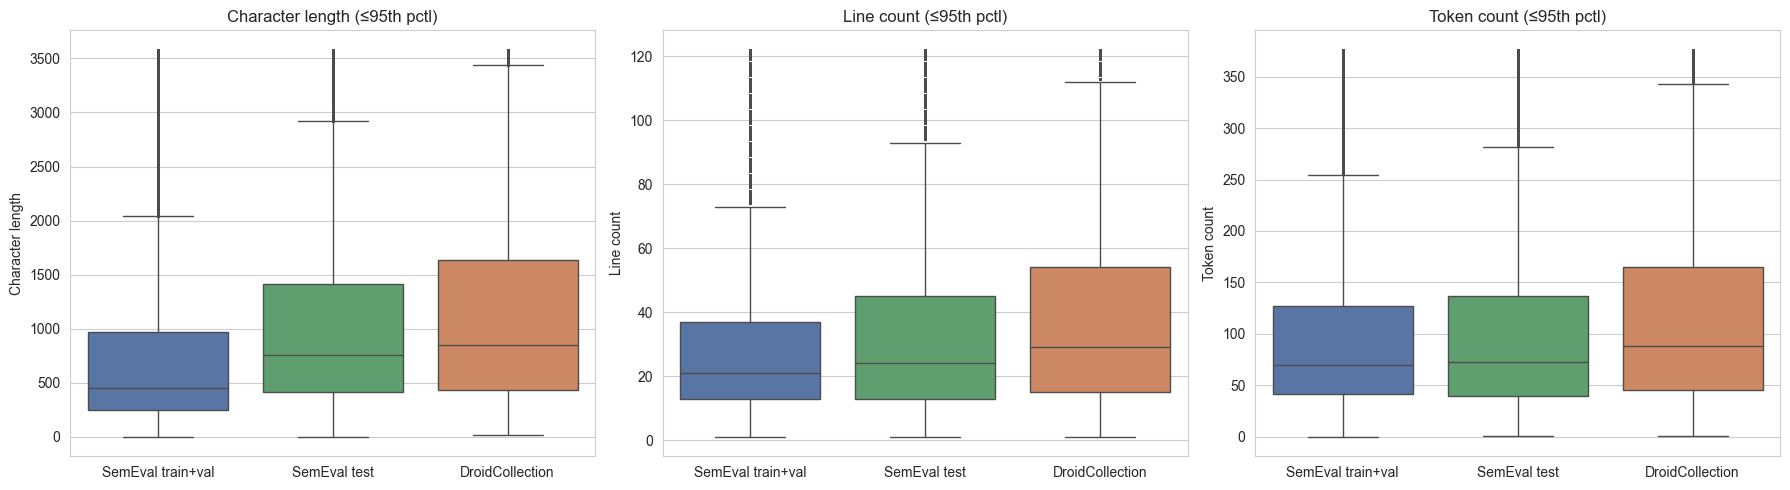

In [16]:
# Box-plots: per dataset for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Character length", "Line count", "Token count"],
):
    upper = combined[col].quantile(0.95)
    sns.boxplot(
        data=combined[combined[col] <= upper],
        x="dataset", y=col, hue="dataset",
        palette=ds_palette, ax=ax, fliersize=1, legend=False,
    )
    ax.set_title(f"{title} (≤95th pctl)")
    ax.set_ylabel(title)
    ax.set_xlabel("")

plt.tight_layout()
plt.show()

### 5d. Summary statistics side-by-side

code_len                            line_count               \
                      mean median     std min     max       mean median   std   
dataset                                                                         
DroidCollection     1356.4  913.0  1351.4  21   34346       44.6   30.0  42.1   
SemEval test        1420.6  843.0  1643.8   2   54080       43.2   26.0  50.0   
SemEval train+val    836.6  463.0  1348.3   0  475006       36.5   22.0  63.4   

                            token_count                           
                  min   max        mean median    std min    max  
dataset                                                           
DroidCollection     1   300       133.5   93.0  128.5   1   3205  
SemEval test        1  3489       132.0   79.0  153.5   1   7587  
SemEval train+val   1  3921       121.6   74.0  161.0   0  23974

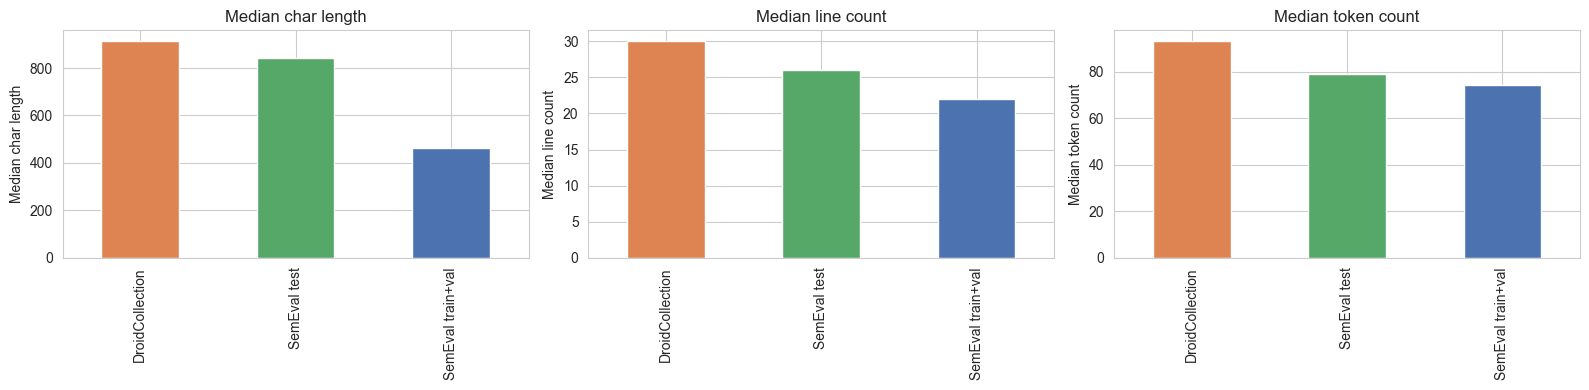

In [17]:
# Descriptive stats per dataset
cross_stats = (
    combined.groupby("dataset")[["code_len", "line_count", "token_count"]]
            .agg(["mean", "median", "std", "min", "max"])
            .round(1)
)
display(cross_stats)

# Median comparison as grouped bar chart
medians = combined.groupby("dataset")[["code_len", "line_count", "token_count"]].median()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
for ax, col, title in zip(
    axes,
    ["code_len", "line_count", "token_count"],
    ["Median char length", "Median line count", "Median token count"],
):
    medians[col].plot.bar(ax=ax, color=[ds_palette[d] for d in medians.index])
    ax.set_title(title)
    ax.set_ylabel(title)
    ax.set_xlabel("")

plt.tight_layout()
plt.show()